# Hypothyroid Disease Classification
### Group 17: Matthew Gillies, Ryan Lee, Eric Liu, Arman Moztarzadeh

## Summary
In this report, we trained a classifier to predict the presence of hyperthyroidism using varying attributes such as age, sex, prior treatment for thyroid disease, and amount of thyroid hormones in the body. Our classifier has a 98% accuracy rate on the test set.

## Introduction
The Thyroid Disease dataset obtained from the UCI Machine Learning Repository will be used to predict the presence of hyperthyroidism. Hyperthyroidism is an issue that occurs when the thyroid gland makes more thyroid hormones than the body needs (De Leo et al., 2016). The body manages its energy by using thyroid hormones. By having an excessive amount, bodily functions may increase in speed resulting in weight loss, rapid heartbeat, fatigue, shaky hands, sweating, and more (U.S. Department of Health and Human Services, n.d.). Within the population, certain groups are more predisposed to getting hyperthyroidism. Hyperthyroidism is more common in women, women who were recently pregnant, type 1 or type 2 diabetes, and several other factors (Allahabadia, 2000). In order to help predict whether someone has hyperthyroidism, we are using 19 attributes provided from the Thyroid Disease dataset. The attributes we are using are age, sex, if they take medication for thyroid disease (thyroxine or antithyroid medication), pregnant status, prior treatment for thyroid disease (thyroid surgery or Ii131 radiotherapy for hyperthyroidism), and amount of different hormones in the body (TSH, TT4, T4U, and FTI). With these factors, we are wondering how accurately we can make a classifier in order to predict whether or not someone has hyperthyroidism or not. 

## Methods and Results

To begin this analysis we read in the data from the original source. The binaryClass feature is manipulated so that all values are either positive or negative, removing all other diagnoses. Next we replace all "?" values with NA's, and then remove columns that are either irrelevant to our classification model or have an extremely large amount of NA values. We then remove all of the remaining rows with NA values from the dataset. Since all of the columns are of datatype object, they are all changed to their respective datatypes (either numeric or categorical). Following this we convert the binaryClass column from positive and negative to 0's and 1's to match the classification model. With this dataset positive labels actually represent a negative diagnosis, so positive values correlate to 0 and negatives correlate to 1. Now that the dataset is cleaned up, we view summary statistics and correlations of the numeric features along with value counts for the entire dataset. This concludes the data tidying and EDA. We split the data into training and testing set with a 70/30 split, while also separating the binaryClass feature from the rest of the dataset. Following this a column transformer is created to scale all numeric variables and one-hot encode all categorical variables to ensure they are in a state that the model can process. This column transformer is then fit on and transforms the training set, along with transforming the test set. We then perform cross-validation on the training set using a pipeline with the column transformer and a LogisticRegression model, which returns a cv score of 98%. The model is then applied to the training set, again producing a 98% accuracy score. We also visualize the training predictions with TSH and TT4 concentrations on the x and y axes respectively. Finally, we apply the model to the test set, which also produces a 98% accuracy. Another plot visualizing the class predictions is created along with a confusion matrix to realize the impact of the predictions. From the confusion matrix we can see that most of our incorrect predictions are false negatives, which are worse in this case as we would rather incorrectly diagnose someone to have hypothyroid disease than incorrectly diagnose someone as disease free.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

In [2]:
if not os.path.exists("data"):
    os.makedirs("data")
path1 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhyper.data'
path2 = 'http://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/allhyper.test'
columnNames = ["age", "sex", "on thyroxine", "query on thyroxine",
               "on antithyroid medication", "sick", "pregnant",
               "thyroid surgery", "I131 treatment", "query hypothyroid",
               "query hyperthyroid", "lithium", "goitre", "tumor",
               "hypopituitary", "psych", "TSH measured", "TSH", "T3 measured",
               "T3", "TT4 measured", "TT4", "T4U measured", "T4U",
               "FTI measured", "FTI", "TBG measured", "TBG", "referral source",
               "binaryClass"]
dfData = pd.read_csv(path1, names=columnNames)
dfTest = pd.read_csv(path2, names=columnNames)
hypothyroid_df = pd.concat([dfData, dfTest])

In [3]:
## Dataset is backwards so P refers to negative and N refers to positive
## Other if statements are to remove various other labels for binary class
for row in range(len(hypothyroid_df)):
    if (hypothyroid_df['binaryClass'].values[row][0] == "n"):
        hypothyroid_df['binaryClass'].values[row] = "P"
    if (hypothyroid_df['binaryClass'].values[row][0] == "h"):
        hypothyroid_df['binaryClass'].values[row] = "N"
    if (hypothyroid_df['binaryClass'].values[row][0] == "T"):
        hypothyroid_df['binaryClass'].values[row] = "?"
    if (hypothyroid_df['binaryClass'].values[row][0] == "g"):
        hypothyroid_df['binaryClass'].values[row] = "?"
    if (hypothyroid_df['binaryClass'].values[row][0] == "s"):
        hypothyroid_df['binaryClass'].values[row] = "?"
hypothyroid_df.to_csv('data/hypothyroid.csv')

In [4]:
## Reading in data
#hypothyroid_df = pd.read_csv("data/hypothyroid.csv")
hypothyroid_df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [5]:
hypothyroid_df.shape

(3772, 30)

In [6]:
## Replacing ? values with NA
hypothyroid = hypothyroid_df.replace("?", np.nan)

In [7]:
hypothyroid.isna().sum()

age                             1
sex                           150
on thyroxine                    0
query on thyroxine              0
on antithyroid medication       0
sick                            0
pregnant                        0
thyroid surgery                 0
I131 treatment                  0
query hypothyroid               0
query hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH measured                    0
TSH                           369
T3 measured                     0
T3                            769
TT4 measured                    0
TT4                           231
T4U measured                    0
T4U                           387
FTI measured                    0
FTI                           385
TBG measured                    0
TBG                          3772
referral source                 0
binaryClass   

In [8]:
## Due to large amount of NA values in TBG and T3 these features will be removed from the dataset. 
## All "measured" features will also be removed as once NA's are removed they will all be "t"
## We will also removed the referral source column as it is quite irrelevant
## All other NA rows will simply be dropped
hypo = hypothyroid.drop(columns = ["TBG", "TBG measured", "T3", "T3 measured", "TSH measured", "TT4 measured", "FTI measured"
                                   , "T4U measured", "referral source"])

In [9]:
hypo_clean = hypo.dropna()

In [10]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3085 entries, 0 to 971
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3085 non-null   object
 1   sex                        3085 non-null   object
 2   on thyroxine               3085 non-null   object
 3   query on thyroxine         3085 non-null   object
 4   on antithyroid medication  3085 non-null   object
 5   sick                       3085 non-null   object
 6   pregnant                   3085 non-null   object
 7   thyroid surgery            3085 non-null   object
 8   I131 treatment             3085 non-null   object
 9   query hypothyroid          3085 non-null   object
 10  query hyperthyroid         3085 non-null   object
 11  lithium                    3085 non-null   object
 12  goitre                     3085 non-null   object
 13  tumor                      3085 non-null   object
 14  hypopitui

In [11]:
## Changing Dtype of the columns to numeric/categorical 
num_cols = ['age', 'TSH', 'TT4', 'T4U', 'FTI']
cat_cols = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych', 'binaryClass',
           'hypopituitary']
hypo_clean[num_cols] = hypo_clean[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
for col in cat_cols:
    hypo_clean[col] = hypo_clean[col].astype('category')

In [12]:
## Changing binaryClass so 0 represents negative and 1 represents positive
hypo_clean['binaryClass'] = hypo_clean['binaryClass'].replace(["N", "P"], [1,0])

In [13]:
hypo_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3085 entries, 0 to 971
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   age                        3085 non-null   float64 
 1   sex                        3085 non-null   category
 2   on thyroxine               3085 non-null   category
 3   query on thyroxine         3085 non-null   category
 4   on antithyroid medication  3085 non-null   category
 5   sick                       3085 non-null   category
 6   pregnant                   3085 non-null   category
 7   thyroid surgery            3085 non-null   category
 8   I131 treatment             3085 non-null   category
 9   query hypothyroid          3085 non-null   category
 10  query hyperthyroid         3085 non-null   category
 11  lithium                    3085 non-null   category
 12  goitre                     3085 non-null   category
 13  tumor                      3085 no

In [14]:
hypo_clean.describe()

,age,TSH,TT4,T4U,FTI
count,3085.000000,3085.000000,3085.000000,3085.000000,3085.00000
mean,52.821718,4.982172,108.694814,0.995246,110.31154
std,20.099428,23.975905,35.763281,0.194844,32.79471
min,1.000000,0.005000,2.000000,0.250000,2.00000
25%,37.000000,0.480000,88.000000,0.880000,93.00000
50%,55.000000,1.300000,104.000000,0.980000,107.00000
75%,68.000000,2.600000,125.000000,1.080000,124.00000
max,455.000000,530.000000,430.000000,2.320000,395.00000


In [15]:
for c in hypo_clean.columns:
    print ("---- %s ---" % c)
    print (hypo_clean[c].value_counts())

---- age ---
70.0    80
59.0    79
60.0    76
73.0    70
55.0    70
        ..
4.0      1
6.0      1
10.0     1
92.0     1
11.0     1
Name: age, Length: 93, dtype: int64
---- sex ---
F    2096
M     989
Name: sex, dtype: int64
---- on thyroxine ---
f    2683
t     402
Name: on thyroxine, dtype: int64
---- query on thyroxine ---
f    3056
t      29
Name: query on thyroxine, dtype: int64
---- on antithyroid medication ---
f    3053
t      32
Name: on antithyroid medication, dtype: int64
---- sick ---
f    2956
t     129
Name: sick, dtype: int64
---- pregnant ---
f    3043
t      42
Name: pregnant, dtype: int64
---- thyroid surgery ---
f    3037
t      48
Name: thyroid surgery, dtype: int64
---- I131 treatment ---
f    3034
t      51
Name: I131 treatment, dtype: int64
---- query hypothyroid ---
f    2877
t     208
Name: query hypothyroid, dtype: int64
---- query hyperthyroid ---
f    2912
t     173
Name: query hyperthyroid, dtype: int64
---- lithium ---
f    3067
t      18
Name: lithium, 

Figure 1: Correlations of numeric features


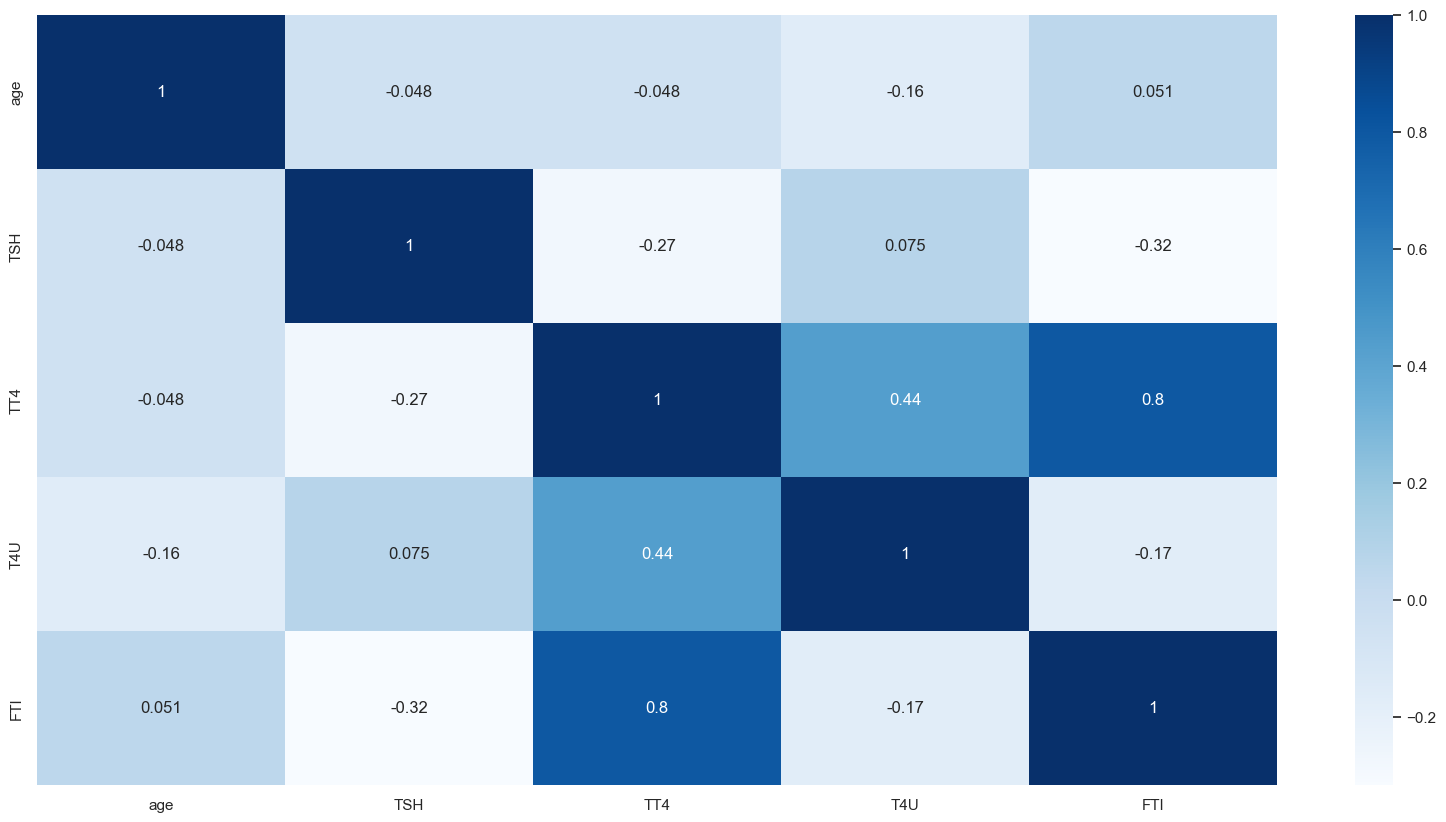

In [16]:
## Visualizing correlations of numeric features
print("Figure 1: Correlations of numeric features")
numeric = hypo_clean[['age', 'TSH', 'TT4', 'T4U', 'FTI']]
cor = numeric.corr()
plt.figure(figsize=(20, 10))
sn.set(font_scale=1)
sn.heatmap(cor, annot=True, cmap=plt.cm.Blues);

In [17]:
print("Figure 2: Realization of class counts")
pd.DataFrame(hypo_clean['binaryClass'].value_counts())

Figure 2: Realization of class counts


,binaryClass
0,3020
1,65


In [18]:
## Splitting data
X = hypo_clean.drop(columns = "binaryClass")
y = hypo_clean['binaryClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,TT4,T4U,FTI
1233,60.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,0.91,102.0,0.91,112.0
851,52.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,2.00,93.0,0.99,95.0
1719,62.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,0.72,78.0,0.95,82.0
68,44.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,0.20,107.0,0.79,135.0
743,41.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,0.15,430.0,1.09,395.0


In [19]:
## Preprocessing data
onehot = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
            'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'psych',
           'hypopituitary']
numeric = ['age', 'TSH', 'TT4', 'T4U', 'FTI']

In [20]:
ct = make_column_transformer(
    (StandardScaler(), numeric), 
    (OneHotEncoder(handle_unknown = 'ignore'), onehot)
)

In [21]:
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)
transformed_X_test

array([[ 1.07290541, -0.09846884,  0.69602423, ...,  0.        ,
         1.        ,  0.        ],
       [-0.2621355 , -0.07744644, -0.53593536, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.12630705, -0.14892259, -1.2359124 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.37868414, -0.18045618,  1.98398198, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.39331523, -0.0858554 , -0.03195189, ...,  0.        ,
         1.        ,  0.        ],
       [-1.65057805, -0.19517186, -0.05995097, ...,  0.        ,
         1.        ,  0.        ]])

In [22]:
## Creating LogisticRegression Classifier
pipe_log = make_pipeline(ct, LogisticRegression(max_iter = 1000, C = 1))
cv = cross_validate(pipe_log, X_train, y_train, error_score = 'raise')
print("Figure 3: Cross-Validation Scores for the Classifier")
pd.DataFrame(cv)

Figure 3: Cross-Validation Scores for the Classifier


,fit_time,score_time,test_score
0,0.041120,0.004455,0.988426
1,0.021440,0.004367,0.986111
2,0.025058,0.004464,0.983796
3,0.020250,0.004358,0.988426
4,0.026161,0.004518,0.983759


Cross validation performs well so this model will be applied to the dataset.

In [23]:
lr = LogisticRegression(max_iter = 1000, C = 1)
X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)
lr.fit(X_train_trans, y_train)
train_preds = lr.predict(X_train_trans)

Figure 4: Visualization of Classification with TSH and TT4 concentration on the axes for training set


Text(0, 0.5, 'TT4 concentration')

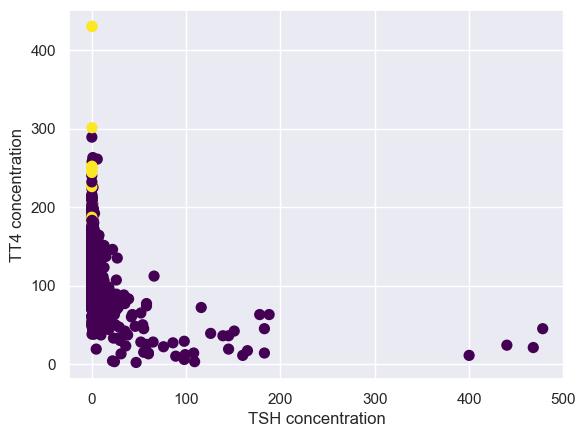

In [24]:
print("Figure 4: Visualization of Classification with TSH and TT4 concentration on the axes for training set")
plt.scatter(X_train["TSH"], X_train["TT4"], c=train_preds, s=50, cmap='viridis')
plt.xlabel("TSH concentration")
plt.ylabel("TT4 concentration")


In [25]:
accuracy_score(train_preds, y_train)

0.9879573876794813

The model produces a very strong 98% accuracy rate on the training data. 

In [26]:
## Test set
test_preds = lr.predict(X_test_trans)

Figure 5: Visualization of Clusters with TSH and TT4 concentration on the axes for test set


Text(0, 0.5, 'TT4 concentration')

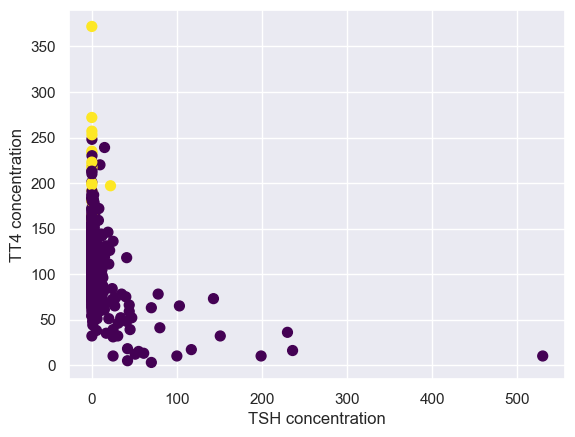

In [27]:
print("Figure 5: Visualization of Clusters with TSH and TT4 concentration on the axes for test set")
plt.scatter(X_test["TSH"], X_test["TT4"], c=test_preds, s=50, cmap='viridis')
plt.xlabel("TSH concentration")
plt.ylabel("TT4 concentration")

In [28]:
accuracy_score(test_preds, y_test)

0.9859611231101512

The model also performs quite well on the test set with a 98% accuracy.

In [29]:
## Confusion Matrix
print("Figure 6: Confusion matrix for test predictions")
pd.DataFrame(confusion_matrix(y_test, test_preds))

Figure 6: Confusion matrix for test predictions


,0,1
0,901,5
1,8,12


## Discussion
The model we trained as a 98% accuracy when tested on a test set. We expected to be able to train a classifier with a high level of accuracy due to the data provided by the dataset. By providing us with measurements of specific thyroid hormones tied to hyperthyroidism, we are able to accurately predict the status of the disease. This classifier could act as another test to back up a doctor’s medical opinion if someone has hyperthyroidism. Additionally, it could lower the barrier of entry for people wondering if they have the disease. Currently, there are at-home thyroid tests you can administer to measure thyroid hormone levels. By lowering the barrier of entry, more potential hyperthyroidism patients can catch their diseases earlier on instead of waiting for a medical appointment. Future projects could at hyperthyroidism disease progression. Hyperthyroidism is a disease that exists on a spectrum and simply saying someone has hyperthyroidism or someone does not is severely oversimplifying the disease. Additionally, other projects could look if the dataset holds out in a modern setting. The dataset was published in 1987 and it has been studied that hyperthyroidism increased between 1987 and 1995 due to an increase in salt in food (Mostbeck et al., 1998)


## References

Allahabadia, A. (2000). Age and gender predict the outcome of treatment for Graves' hyperthyroidism. Journal of Clinical Endocrinology & Metabolism, 85(3), 1038–1042. https://doi.org/10.1210/jc.85.3.1038

De Leo, S., Lee, S. Y., & Braverman, L. E. (2016). Hyperthyroidism. The Lancet, 388(10047), 906–918. https://doi.org/10.1016/s0140-6736(16)00278-6

Mostbeck, A., Galvan, G., Bauer, P., Eber, O., Atefie, K., Dam, K., Feichtinger, H., Fritzsche, H., Haydl, H., Köhn, H., König, B., Koriska, K., Kroiss, A., Lind, P., Markt, B., Maschek, W., Pesl, H., Ramschak-Schwarzer, S., Riccabona, G., … Zechmann, W. (1998). The incidence of hyperthyroidism in Austria from 1987 to 1995 before and after an increase in salt iodization in 1990. European Journal of Nuclear Medicine and Molecular Imaging, 25(4), 367–374. https://doi.org/10.1007/s002590050234


U.S. Department of Health and Human Services. (n.d.). Hyperthyroidism (overactive thyroid). National Institute of Diabetes and Digestive and Kidney Diseases. Retrieved February 17, 2023, from https://www.niddk.nih.gov/health-information/endocrine-diseases/hyperthyroidism
